In [ ]:
#@title Setup Repository
import os
os.chdir('/content')
CODE_DIR = 'HFGI'

!git clone https://github.com/Tengfei-Wang/HFGI.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2

## Step 1: Download & Load Pretrained Models 
We provide pretrained models for face editing.

In [ ]:
#@title Download
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "checkpoint")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url    

path = {"id": "19y6pxOiJWB0NoG3fAZO9Eab66zkN9XIL", "name": "ckpt.pt"}
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

!wget {download_command}

In [19]:
model_path = "checkpoint/ckpt.pt"
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
opts['is_train'] = False
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading basic encoder from checkpoint: checkpoint/ckpt.pt
Model successfully loaded!


## Step 2: Set up Input Images

We load the input image and align it (optional).

In [20]:
# Setup required image transformations
EXPERIMENT_ARGS = {
        "image_path": "test_imgs/00044.jpg"
    }

EXPERIMENT_ARGS['transform'] = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
resize_dims = (256, 256)

In [21]:
image_path = EXPERIMENT_ARGS["image_path"]
original_image = Image.open(image_path)
original_image = original_image.convert("RGB")

run_align = True

### Image Alignment

In [22]:
import numpy as np
import PIL
import PIL.Image
import scipy
import scipy.ndimage
import dlib


def get_landmark(filepath, predictor):
    """get landmark with dlib
    :return: np.array shape=(68, 2)
    """
    detector = dlib.get_frontal_face_detector()

    img = dlib.load_rgb_image(filepath)
    dets = detector(img, 1)

    for k, d in enumerate(dets):
        shape = predictor(img, d)

    t = list(shape.parts())
    a = []
    for tt in t:
        a.append([tt.x, tt.y])
    lm = np.array(a)
    return lm


def align_face(filepath, predictor):
    """
    :param filepath: str
    :return: PIL Image
    """

    lm = get_landmark(filepath, predictor)

    lm_chin = lm[0: 17]  # left-right
    lm_eyebrow_left = lm[17: 22]  # left-right
    lm_eyebrow_right = lm[22: 27]  # left-right
    lm_nose = lm[27: 31]  # top-down
    lm_nostrils = lm[31: 36]  # top-down
    lm_eye_left = lm[36: 42]  # left-clockwise
    lm_eye_right = lm[42: 48]  # left-clockwise
    lm_mouth_outer = lm[48: 60]  # left-clockwise
    lm_mouth_inner = lm[60: 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left = np.mean(lm_eye_left, axis=0)
    eye_right = np.mean(lm_eye_right, axis=0)
    eye_avg = (eye_left + eye_right) * 0.5
    eye_to_eye = eye_right - eye_left
    mouth_left = lm_mouth_outer[0]
    mouth_right = lm_mouth_outer[6]
    mouth_avg = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # read image
    img = PIL.Image.open(filepath)

    output_size = 256
    transform_size = 256
    enable_padding = True

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink

    # Crop.
    border = max(int(np.rint(qsize * 0.1)), 3)
    crop = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
            int(np.ceil(max(quad[:, 1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]),
            min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]

    # Pad.
    pad = (int(np.floor(min(quad[:, 0]))), int(np.floor(min(quad[:, 1]))), int(np.ceil(max(quad[:, 0]))),
           int(np.ceil(max(quad[:, 1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0),
           max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w - 1 - x) / pad[2]),
                          1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h - 1 - y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0, 1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)

    # Return aligned image.
    return img

Aligned image has shape: (256, 256)


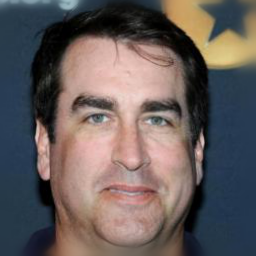

In [23]:
if  'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if run_align:
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

In [24]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

## Step 3: High-Fidelity Inversion

In [25]:
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def get_latents(net, x, is_cars=False):
    codes = net.encoder(x)
    if net.opts.start_from_latent_avg:
        if codes.ndim == 2:
            codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)[:, 0, :]
        else:
            codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)
    if codes.shape[1] == 18 and is_cars:
        codes = codes[:, :16, :]
    return codes

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Inference took 0.7574 seconds.


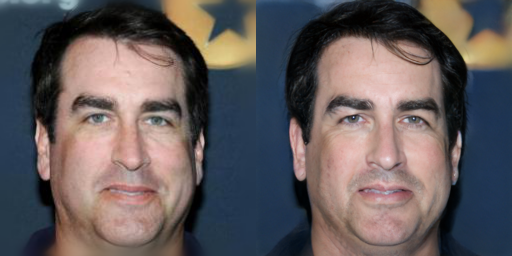

In [26]:
with torch.no_grad():
    x = transformed_image.unsqueeze(0).cuda()

    tic = time.time()
    latent_codes = get_latents(net, x)
    
    # calculate the distortion map
    imgs, _ = net.decoder([latent_codes[0].unsqueeze(0).cuda()],None, input_is_latent=True, randomize_noise=False, return_latents=True)
    res = x -  torch.nn.functional.interpolate(torch.clamp(imgs, -1., 1.), size=(256,256) , mode='bilinear')

    # ADA
    img_edit = torch.nn.functional.interpolate(torch.clamp(imgs, -1., 1.), size=(256,256) , mode='bilinear')
    res_align  = net.grid_align(torch.cat((res, img_edit  ), 1))

    # consultation fusion
    conditions = net.residue(res_align)

    result_image, _ = net.decoder([latent_codes],conditions, input_is_latent=True, randomize_noise=False, return_latents=True)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image[0]), input_image)

## Step 4: High-Fidelity Editing

In [27]:
from editings import latent_editor
editor = latent_editor.LatentEditor(net.decoder)

In [28]:
# interface-GAN
interfacegan_directions = {
        'age': './editings/interfacegan_directions/age.pt',
        'smile': './editings/interfacegan_directions/smile.pt' }
edit_direction = torch.load(interfacegan_directions['smile']).cuda()
edit_degree = 1.5

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


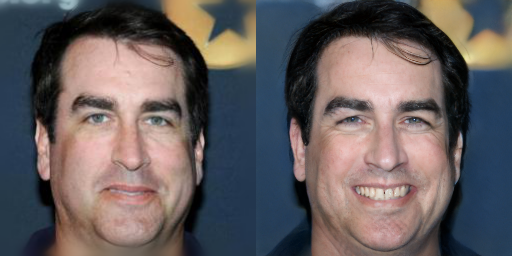

In [29]:
img_edit, edit_latents = editor.apply_interfacegan(latent_codes[0].unsqueeze(0).cuda(), edit_direction, factor=edit_degree)
# align the distortion map
img_edit = torch.nn.functional.interpolate(torch.clamp(img_edit, -1., 1.), size=(256,256) , mode='bilinear')
res_align  = net.grid_align(torch.cat((res, img_edit  ), 1))

# fusion
conditions = net.residue(res_align)
result, _ = net.decoder([edit_latents],conditions, input_is_latent=True, randomize_noise=False, return_latents=True)

result = torch.nn.functional.interpolate(result, size=(256,256) , mode='bilinear')
display_alongside_source_image(tensor2im(result[0]), input_image)

In [30]:
# GANSpace
ganspace_pca = torch.load('./editings/ganspace_pca/ffhq_pca.pt') 
ganspace_directions = {
    'eyes':            (54,  7,  8,  20),
    'beard':           (58,  7,  9,  -20),
    'lip':             (34, 10, 11,  20) }            
edit_direction = ganspace_directions['beard']

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


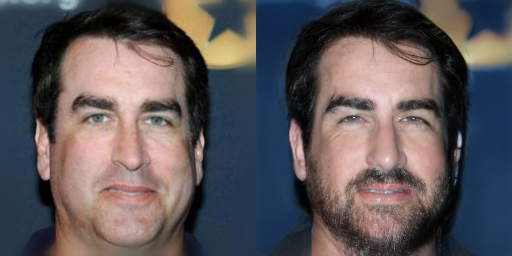

In [31]:
img_edit, edit_latents = editor.apply_ganspace(latent_codes[0].unsqueeze(0).cuda(), ganspace_pca, [edit_direction])
# align the distortion map
img_edit = torch.nn.functional.interpolate(torch.clamp(img_edit, -1., 1.), size=(256,256) , mode='bilinear')
res_align  = net.grid_align(torch.cat((res, img_edit  ), 1))
conditions = net.residue(res_align)
result, _ = net.decoder([edit_latents],conditions, input_is_latent=True, randomize_noise=False, return_latents=True)
result = torch.nn.functional.interpolate(result, size=(256,256) , mode='bilinear')
display_alongside_source_image(tensor2im(result[0]), input_image)